# **The Pythagorean Expectation**
The Pythagorean expectation is an idea devised by the famous baseball analyst, Bill James, but it can in fact be applied to any sport.

In any sports league, teams win games by accumulating a higher total than opponent. 

The Pythagorean expectation can be described thus: in any season, the percentage of games won will be proportional to the square of total points scored by the team squared divided by the sum of total points scored by the team squared plus total points conceded by the team squared.

or WPC = TF2 / ( TF2 + TA2 )

Where TF is points scored and TA is points conceded.

This is a concept which can help to explain not only why teams are successful, but also can be used as the basis for predicting results in the future.

We are going to derive the Pythagorean expectation for the 2022 NFL season.

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Import Data

In [2]:
df = pd.read_excel('NFL_TEAM_STATS_2022.xlsx')
df.head()

,BIGDATABALL\nDATASET,GAME-ID,DATE,WEEK,START\nTIME\n(ET),TEAM,VENUE,Q1,Q2,Q3,Q4,OT,FINAL,1ST DOWNS,RUSH ATT,RUSH YDS,RUSH TD,PASS COMP,PASS ATT,PASS YDS,PASS TD,INT THROWN,SACKED,SACK YARDS,NET \nPASS \nYARDS,TOTAL \nYARDS,FUMBLES,FUMBLES LOST,TURNOVERS,PENALTIES,PENALTY YARDS,3RD DOWNS \nMADE,3RD DOWNS ATT,4TH DOWNS MADE,4TH DOWNS ATT,TOTAL \nPLAYS,TIME \nOF \nPOSSESSION,DEF SACKS,OPP FUMBLES RECOVERED,DEF FUMBLE RECOVERY TD,INT RETURN TD,BLOCKED PUNT/FG RETURN TD,PUNT/KICKOFF/FG RETURN TD,XP RETURN,DEF 2PT CONVERSION RETURN,SAFETIES,BLOCKED KICK/PUNT,INT MADE,2P CONVERSIONS MADE,XP MADE,FG MADE,PTS ALLOWED \nBY DEFENSE,OPENING ODDS,OPENING SPREAD,OPENING TOTAL,LINE \nMOVEMENTS\n1,LINE \nMOVEMENTS\n2,LINE \nMOVEMENTS\n3,CLOSING ODDS,CLOSING SPREAD,CLOSING TOTAL,MONEYLINE,HALFTIME,SEASON
0,NFL 2022 Regular Season,44812-BUF@LAR,2022-09-08,1,8:20 PM,Buffalo Bills,Road,7,3,7,14,NaN,31,23,25,121,1,26,31,297,3,2,2,5,292,413,2,2,4,5,35,9,10,0,0,58,31.233333,7,0,0,0,0,0,0,0,0,0,3,0,4,1,10,-2.5 -10,-2.5,52.0,-2.5,-1.5,-2.5,-1.5 -18,-1.5,52.0,-130,+11.5 -25,2022
1,NFL 2022 Regular Season,44812-BUF@LAR,2022-09-08,1,8:20 PM,Los Angeles Rams,Home,0,10,0,0,NaN,10,19,18,52,0,29,41,240,1,3,7,49,191,243,1,0,3,4,30,6,13,2,3,66,28.766667,2,2,0,0,0,0,0,0,0,0,2,0,1,1,31,52u -10,2.5,52.0,u52,o52,u51.5,52u -12,1.5,52.0,+109,26u -13,2022
2,NFL 2022 Regular Season,44815-NOR@ATL,2022-09-11,1,1:00 PM,New Orleans Saints,Road,7,0,3,17,NaN,27,18,19,151,1,23,34,269,2,0,4,35,234,385,1,1,1,8,99,4,13,0,0,57,26.266667,0,2,0,0,0,0,0,0,0,0,0,1,1,2,26,-5 -10,-5.0,41.5,-5.5,-5.5,-5.5,-5.5 -10,-5.5,44.0,-240,-5.5 -18,2022
3,NFL 2022 Regular Season,44815-NOR@ATL,2022-09-11,1,1:00 PM,Atlanta Falcons,Home,3,13,7,3,NaN,26,26,38,201,2,20,33,215,0,0,0,0,215,416,3,2,2,8,55,5,13,0,0,71,33.733333,4,1,0,0,0,0,0,0,0,0,0,0,2,4,27,41.5u -14,5.0,41.5,u43.5,o44,u43.5,44u -15,5.5,44.0,+199,21.5u -13,2022
4,NFL 2022 Regular Season,44815-CLE@CAR,2022-09-11,1,1:00 PM,Cleveland Browns,Road,0,17,3,6,NaN,26,23,39,217,1,18,34,147,1,0,1,9,138,355,1,0,0,9,71,8,18,1,2,74,38.433333,4,0,0,0,0,0,0,0,0,0,1,0,2,4,24,41.5o -10,1.5,41.5,o42,o42,o42,41.5o -13,1.5,41.5,+105,20.5o -04,2022


## Convert Column Names

In [3]:
df.rename(columns = {'BIGDATABALL\nDATASET':'SEASON TYPE','GAME-ID':'GAME_ID','START\nTIME\n(ET)':'START TIME','FINAL':'TOTAL PTS','NET \nPASS \nYARDS':'NET PASS YDS',
                               'TOTAL \nYARDS':'TOTAL YARDS','3RD DOWNS \nMADE':'3RD DOWNS MADE','TOTAL \nPLAYS':'TOTAL PLAYS',
                               'TIME \nOF \nPOSSESSION':'TIME OF POSS','PTS ALLOWED \nBY DEFENSE':'PTS ALLOWED BY DEF','LINE \nMOVEMENTS \n 1':'LINE MOVEMENTS 1',
                               'LINE \nMOVEMENTS \n 2':'LINE MOVEMENTS 2','LINE \nMOVEMENTS \n 3':'LINE MOVEMENTS 3',
                               }, inplace = True)

## Add Opponent Fields to Rows

In [4]:
def add_opponent_columns(df):
    # Create an empty DataFrame to hold the results
    new_df = pd.DataFrame()
    
    # Group by 'GAME_ID' and iterate through each group
    for game_id, group_df in df.groupby('GAME_ID'):
        # If there are not exactly 2 teams, we skip
        if len(group_df) != 2:
            continue
        
        # Extract team names and their corresponding total points
        team1, team2 = group_df['TEAM'].values
        pts1, pts2 = group_df['TOTAL PTS'].values
        
        # Add 'OPPONENT' and 'OPP TOTAL PTS' columns
        group_df['OPPONENT'] = group_df['TEAM'].apply(lambda x: team2 if x == team1 else team1)
        group_df['OPP TOTAL PTS'] = group_df['TEAM'].apply(lambda x: pts2 if x == team1 else pts1)
        
        # Append the modified group DataFrame to the new DataFrame
        new_df = pd.concat([new_df, group_df])
    
    return new_df

df = add_opponent_columns(df)
df.head()

,SEASON TYPE,GAME_ID,DATE,WEEK,START TIME,TEAM,VENUE,Q1,Q2,Q3,Q4,OT,TOTAL PTS,1ST DOWNS,RUSH ATT,RUSH YDS,RUSH TD,PASS COMP,PASS ATT,PASS YDS,PASS TD,INT THROWN,SACKED,SACK YARDS,NET PASS YDS,TOTAL YARDS,FUMBLES,FUMBLES LOST,TURNOVERS,PENALTIES,PENALTY YARDS,3RD DOWNS MADE,3RD DOWNS ATT,4TH DOWNS MADE,4TH DOWNS ATT,TOTAL PLAYS,TIME OF POSS,DEF SACKS,OPP FUMBLES RECOVERED,DEF FUMBLE RECOVERY TD,INT RETURN TD,BLOCKED PUNT/FG RETURN TD,PUNT/KICKOFF/FG RETURN TD,XP RETURN,DEF 2PT CONVERSION RETURN,SAFETIES,BLOCKED KICK/PUNT,INT MADE,2P CONVERSIONS MADE,XP MADE,FG MADE,PTS ALLOWED BY DEF,OPENING ODDS,OPENING SPREAD,OPENING TOTAL,LINE \nMOVEMENTS\n1,LINE \nMOVEMENTS\n2,LINE \nMOVEMENTS\n3,CLOSING ODDS,CLOSING SPREAD,CLOSING TOTAL,MONEYLINE,HALFTIME,SEASON,OPPONENT,OPP TOTAL PTS
0,NFL 2022 Regular Season,44812-BUF@LAR,2022-09-08,1,8:20 PM,Buffalo Bills,Road,7,3,7,14,NaN,31,23,25,121,1,26,31,297,3,2,2,5,292,413,2,2,4,5,35,9,10,0,0,58,31.233333,7,0,0,0,0,0,0,0,0,0,3,0,4,1,10,-2.5 -10,-2.5,52.0,-2.5,-1.5,-2.5,-1.5 -18,-1.5,52.0,-130,+11.5 -25,2022,Los Angeles Rams,10
1,NFL 2022 Regular Season,44812-BUF@LAR,2022-09-08,1,8:20 PM,Los Angeles Rams,Home,0,10,0,0,NaN,10,19,18,52,0,29,41,240,1,3,7,49,191,243,1,0,3,4,30,6,13,2,3,66,28.766667,2,2,0,0,0,0,0,0,0,0,2,0,1,1,31,52u -10,2.5,52.0,u52,o52,u51.5,52u -12,1.5,52.0,+109,26u -13,2022,Buffalo Bills,31
14,NFL 2022 Regular Season,44815-BAL@NYJ,2022-09-11,1,1:00 PM,Baltimore Ravens,Road,3,7,14,0,NaN,24,13,21,63,0,17,30,213,3,1,2,2,211,274,1,0,1,5,29,5,13,0,0,53,27.500000,3,1,0,0,0,0,0,0,0,0,1,0,3,1,9,-6 -10,-6.0,45.0,-6.5,-6.5,-6.5,-6.5 -10,-6.5,44.0,-300,-2.5 -23,2022,New York Jets,9
15,NFL 2022 Regular Season,44815-BAL@NYJ,2022-09-11,1,1:00 PM,New York Jets,Home,0,3,0,6,NaN,9,24,17,83,0,37,59,309,1,1,3,12,297,380,2,1,2,6,81,2,14,3,4,79,32.500000,2,0,0,0,0,0,0,0,0,0,1,0,0,1,24,45u -10,6.0,45.0,u44,u44,u44,44u -09,6.5,44.0,+243,20.5u -20,2022,Baltimore Ravens,24
4,NFL 2022 Regular Season,44815-CLE@CAR,2022-09-11,1,1:00 PM,Cleveland Browns,Road,0,17,3,6,NaN,26,23,39,217,1,18,34,147,1,0,1,9,138,355,1,0,0,9,71,8,18,1,2,74,38.433333,4,0,0,0,0,0,0,0,0,0,1,0,2,4,24,41.5o -10,1.5,41.5,o42,o42,o42,41.5o -13,1.5,41.5,+105,20.5o -04,2022,Carolina Panthers,24


## Add W/L & Point Margin to Rows

In [5]:
def win_loss_margin(df):
    # Create 'Home Win' column
    df['HOME WIN'] = ((df['TOTAL PTS'] > df['OPP TOTAL PTS']) & (df['VENUE'] == 'Home')).astype(int)
    
    # Create 'Road Win' column
    df['ROAD WIN'] = ((df['TOTAL PTS'] > df['OPP TOTAL PTS']) & (df['VENUE'] == 'Road')).astype(int)
    
    # Create 'W/L' column
    df['W/L'] = (df['TOTAL PTS'] > df['OPP TOTAL PTS']).astype(int)
    
    # Create 'PT MARGIN' column
    df['PT MARGIN'] = df['TOTAL PTS'] - df['OPP TOTAL PTS']

    return df

# Apply the function to DataFrames
df = win_loss_margin(df)

df.head()

,SEASON TYPE,GAME_ID,DATE,WEEK,START TIME,TEAM,VENUE,Q1,Q2,Q3,Q4,OT,TOTAL PTS,1ST DOWNS,RUSH ATT,RUSH YDS,RUSH TD,PASS COMP,PASS ATT,PASS YDS,PASS TD,INT THROWN,SACKED,SACK YARDS,NET PASS YDS,TOTAL YARDS,FUMBLES,FUMBLES LOST,TURNOVERS,PENALTIES,PENALTY YARDS,3RD DOWNS MADE,3RD DOWNS ATT,4TH DOWNS MADE,4TH DOWNS ATT,TOTAL PLAYS,TIME OF POSS,DEF SACKS,OPP FUMBLES RECOVERED,DEF FUMBLE RECOVERY TD,INT RETURN TD,BLOCKED PUNT/FG RETURN TD,PUNT/KICKOFF/FG RETURN TD,XP RETURN,DEF 2PT CONVERSION RETURN,SAFETIES,BLOCKED KICK/PUNT,INT MADE,2P CONVERSIONS MADE,XP MADE,FG MADE,PTS ALLOWED BY DEF,OPENING ODDS,OPENING SPREAD,OPENING TOTAL,LINE \nMOVEMENTS\n1,LINE \nMOVEMENTS\n2,LINE \nMOVEMENTS\n3,CLOSING ODDS,CLOSING SPREAD,CLOSING TOTAL,MONEYLINE,HALFTIME,SEASON,OPPONENT,OPP TOTAL PTS,HOME WIN,ROAD WIN,W/L,PT MARGIN
0,NFL 2022 Regular Season,44812-BUF@LAR,2022-09-08,1,8:20 PM,Buffalo Bills,Road,7,3,7,14,NaN,31,23,25,121,1,26,31,297,3,2,2,5,292,413,2,2,4,5,35,9,10,0,0,58,31.233333,7,0,0,0,0,0,0,0,0,0,3,0,4,1,10,-2.5 -10,-2.5,52.0,-2.5,-1.5,-2.5,-1.5 -18,-1.5,52.0,-130,+11.5 -25,2022,Los Angeles Rams,10,0,1,1,21
1,NFL 2022 Regular Season,44812-BUF@LAR,2022-09-08,1,8:20 PM,Los Angeles Rams,Home,0,10,0,0,NaN,10,19,18,52,0,29,41,240,1,3,7,49,191,243,1,0,3,4,30,6,13,2,3,66,28.766667,2,2,0,0,0,0,0,0,0,0,2,0,1,1,31,52u -10,2.5,52.0,u52,o52,u51.5,52u -12,1.5,52.0,+109,26u -13,2022,Buffalo Bills,31,0,0,0,-21
14,NFL 2022 Regular Season,44815-BAL@NYJ,2022-09-11,1,1:00 PM,Baltimore Ravens,Road,3,7,14,0,NaN,24,13,21,63,0,17,30,213,3,1,2,2,211,274,1,0,1,5,29,5,13,0,0,53,27.500000,3,1,0,0,0,0,0,0,0,0,1,0,3,1,9,-6 -10,-6.0,45.0,-6.5,-6.5,-6.5,-6.5 -10,-6.5,44.0,-300,-2.5 -23,2022,New York Jets,9,0,1,1,15
15,NFL 2022 Regular Season,44815-BAL@NYJ,2022-09-11,1,1:00 PM,New York Jets,Home,0,3,0,6,NaN,9,24,17,83,0,37,59,309,1,1,3,12,297,380,2,1,2,6,81,2,14,3,4,79,32.500000,2,0,0,0,0,0,0,0,0,0,1,0,0,1,24,45u -10,6.0,45.0,u44,u44,u44,44u -09,6.5,44.0,+243,20.5u -20,2022,Baltimore Ravens,24,0,0,0,-15
4,NFL 2022 Regular Season,44815-CLE@CAR,2022-09-11,1,1:00 PM,Cleveland Browns,Road,0,17,3,6,NaN,26,23,39,217,1,18,34,147,1,0,1,9,138,355,1,0,0,9,71,8,18,1,2,74,38.433333,4,0,0,0,0,0,0,0,0,0,1,0,2,4,24,41.5o -10,1.5,41.5,o42,o42,o42,41.5o -13,1.5,41.5,+105,20.5o -04,2022,Carolina Panthers,24,0,1,1,2


## Create New DF for Pythagorean Expectation

In [6]:
# TOTAL PTS = TEAM PTS, OPP TOTAL PTS = OPPONENT PTS
pyth_df = df[['TEAM', 'OPPONENT', 'TOTAL PTS', 'OPP TOTAL PTS', 'HOME WIN', 'ROAD WIN', 'W/L', 'PT MARGIN']]
pyth_df['COUNT'] = 1
pyth_df.head()

/opt/anaconda3/envs/algo_trading/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,TEAM,OPPONENT,TOTAL PTS,OPP TOTAL PTS,HOME WIN,ROAD WIN,W/L,PT MARGIN,COUNT
0,Buffalo Bills,Los Angeles Rams,31,10,0,1,1,21,1
1,Los Angeles Rams,Buffalo Bills,10,31,0,0,0,-21,1
14,Baltimore Ravens,New York Jets,24,9,0,1,1,15,1
15,New York Jets,Baltimore Ravens,9,24,0,0,0,-15,1
4,Cleveland Browns,Carolina Panthers,26,24,0,1,1,2,1


## Calculate Points For/Against, Wins, Games Played, Win%, and Pythagorean Expectation

In [7]:
teams = pyth_df.groupby('TEAM')['TOTAL PTS','OPP TOTAL PTS', 'W/L','COUNT'].sum().reset_index()
teams = teams.rename(columns={'TOTAL PTS':'PTS FOR', 'OPP TOTAL PTS':'PTS AG', 'W/L':'WINS','COUNT':'GAMES'})
teams['WPC'] = teams['WINS']/teams['GAMES']
teams['PYTH'] = teams['PTS FOR']**2/(teams['PTS FOR']**2 + teams['PTS AG']**2)
teams

/opt/anaconda3/envs/algo_trading/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,TEAM,PTS FOR,PTS AG,WINS,GAMES,WPC,PYTH
0,Arizona Cardinals,340,449,4,17,0.235294,0.364438
1,Atlanta Falcons,365,386,7,17,0.411765,0.472059
2,Baltimore Ravens,367,339,10,18,0.555556,0.539598
3,Buffalo Bills,499,344,14,18,0.777778,0.677854
4,Carolina Panthers,347,374,7,17,0.411765,0.462604
5,Chicago Bears,326,463,3,17,0.176471,0.331444
6,Cincinnati Bengals,489,372,14,19,0.736842,0.633425
7,Cleveland Browns,361,381,7,17,0.411765,0.473065
8,Dallas Cowboys,510,375,13,19,0.684211,0.649074
9,Denver Broncos,287,359,5,17,0.294118,0.389912


## Plot the Data

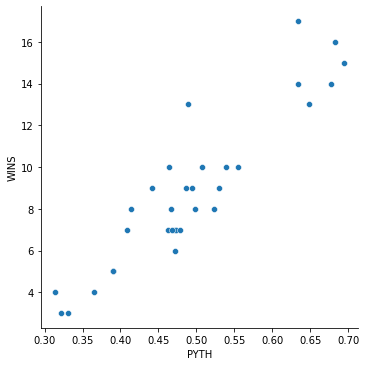

In [8]:
sns.relplot(x="PYTH", y="WINS", data= teams)

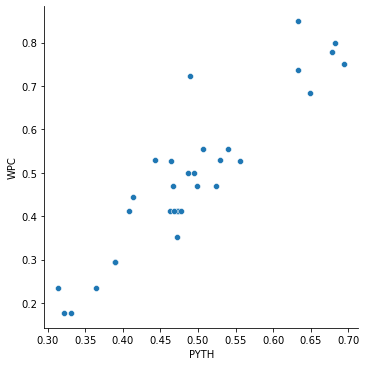

In [9]:
sns.relplot(x="PYTH", y="WPC", data= teams)

## Generate Regression Summary

The regression output tells you many things about the fitted relationship between win percentage and the Pythagorean Expectation. Regression is a method for identifying an equation which best fits the data. In this case that relationship is

wpc = Intercept + coef * pyth

You can see the value of Intercept is -0.3003 and coef is 1.6053. It's this latter value were interested in. It means that for every one unit increase in pyth, the value of wpc goes up by 1.6053.

Two other points to note:

(i) The standard error (std err) gives us an idea of the precision of the estimate. The ratio of the coefficient (coef) to the standard error is called the t statistic (t) and its value informs us about statistical significance. This is illustrated by the p-value (P > |t|) - this is the probability that we would observe the value 1.6053 by chance, if the true value were really zero. This probability here is 0.000 - (this is not exactly zero, but the table doesn't include enough decimal places to show this) which means we are confident it is not zero. By convention, it is usual to conclude that we cannot be confident that the value of the coefficient is not zero if the p-value is greater than .05

(ii) in the top right hand corner of the table is the R-squared. This statistic tells you the percentage of variation in the y-variable (WPC) which can be accounted for by the variation in the x variables (PYTH). R-squared can be thought of as a percentage - here the Pythagorean Expectation can account for 84.4% of the variation in win percentage.

- ols = order least squares (standard form of regression)
- WPC is a function of PYTH, '~' means we run a regression of whats on the left on the variable on the right.
- PYTH coef(1.6053) / PYTH std err(.126) = pyth t-statistic(12.749)
- t-statisitc relates coefficient to standard error and gives a sense of how reliable the data is or

In [10]:
pyth_lm = smf.ols(formula = 'WPC ~ PYTH', data=teams).fit()
pyth_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    WPC   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     162.5
Date:                Thu, 28 Sep 2023   Prob (F-statistic):           1.21e-13
Time:                        07:15:17   Log-Likelihood:                 39.712
No. Observations:                  32   AIC:                            -75.42
Df Residuals:                      30   BIC:                            -72.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3003      0.063     -4.753      0.000      -0.429      -0.171
PYTH           1.6053      0.126     12.749      0.000       1.348       1.862
==============================================================================
Omnibus:                       15.920   Durbin-Watson:                   2.517
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.906
Skew:                           1.439   Prob(JB):                     0.000129
Kurtosis:                       5.269   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Pythagorean Prediction

In [12]:
# Split df in first and second half of season
first_half_df = df[:246]

# TOTAL PTS = TEAM PTS, OPP TOTAL PTS = OPPONENT PTS
first_half_pred_df = first_half_df[['TEAM', 'OPPONENT', 'TOTAL PTS', 'OPP TOTAL PTS', 'HOME WIN', 'ROAD WIN', 'W/L', 'PT MARGIN']].reset_index(drop=True)
first_half_pred_df['COUNT'] = 1

first_half_perf = first_half_pred_df.groupby('TEAM')['TOTAL PTS','OPP TOTAL PTS', 'W/L','COUNT'].sum().reset_index()
first_half_perf = first_half_perf.rename(columns={'TOTAL PTS':'PTS FOR1', 'OPP TOTAL PTS':'PTS AG1', 'W/L':'WINS1','COUNT':'GAMES1'})
first_half_perf['WPC1'] = first_half_perf['WINS1']/first_half_perf['GAMES1']
first_half_perf['PYTH1'] = first_half_perf['PTS FOR1']**2/(first_half_perf['PTS FOR1']**2 + first_half_perf['PTS AG1']**2)
first_half_perf

/opt/anaconda3/envs/algo_trading/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,TEAM,PTS FOR1,PTS AG1,WINS1,GAMES1,WPC1,PYTH1
0,Arizona Cardinals,182,210,3,8,0.375000,0.428934
1,Atlanta Falcons,200,205,4,8,0.500000,0.487656
2,Baltimore Ravens,208,183,5,8,0.625000,0.563678
3,Buffalo Bills,203,98,6,7,0.857143,0.810993
4,Carolina Panthers,158,186,2,8,0.250000,0.419140
5,Chicago Bears,155,181,3,8,0.375000,0.423080
6,Cincinnati Bengals,186,164,4,8,0.500000,0.562610
7,Cleveland Browns,200,199,3,8,0.375000,0.502506
8,Dallas Cowboys,183,133,6,8,0.750000,0.654363
9,Denver Broncos,121,132,3,8,0.375000,0.456604


In [15]:
# Split df in first and second half of season
second_half_df = df[246:]

# TOTAL PTS = TEAM PTS, OPP TOTAL PTS = OPPONENT PTS
second_half_pred_df = second_half_df[['TEAM', 'OPPONENT', 'TOTAL PTS', 'OPP TOTAL PTS', 'HOME WIN', 'ROAD WIN', 'W/L', 'PT MARGIN']].reset_index(drop=True)
second_half_pred_df['COUNT'] = 1

second_half_perf = second_half_pred_df.groupby('TEAM')['TOTAL PTS','OPP TOTAL PTS', 'W/L','COUNT'].sum().reset_index()
second_half_perf = second_half_perf.rename(columns={'TOTAL PTS':'PTS FOR2', 'OPP TOTAL PTS':'PTS AG2', 'W/L':'WINS2','COUNT':'GAMES2'})
second_half_perf['WPC2'] = second_half_perf['WINS2']/second_half_perf['GAMES2']
second_half_perf['PYTH2'] = second_half_perf['PTS FOR2']**2/(second_half_perf['PTS FOR2']**2 + second_half_perf['PTS AG2']**2)
second_half_perf

/opt/anaconda3/envs/algo_trading/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,TEAM,PTS FOR2,PTS AG2,WINS2,GAMES2,WPC2,PYTH2
0,Arizona Cardinals,158,239,1,9,0.111111,0.304124
1,Atlanta Falcons,165,181,3,9,0.333333,0.453856
2,Baltimore Ravens,159,156,5,10,0.500000,0.509523
3,Buffalo Bills,296,246,8,11,0.727273,0.591472
4,Carolina Panthers,189,188,5,9,0.555556,0.502653
5,Chicago Bears,171,282,0,9,0.000000,0.268846
6,Cincinnati Bengals,303,208,10,11,0.909091,0.679699
7,Cleveland Browns,161,182,4,9,0.444444,0.439004
8,Dallas Cowboys,327,242,7,11,0.636364,0.646124
9,Denver Broncos,166,227,2,9,0.222222,0.348435


In [16]:
# Merge first and second half results
second_half_predictor = pd.merge(first_half_perf,second_half_perf, on='TEAM')
second_half_predictor

,TEAM,PTS FOR1,PTS AG1,WINS1,GAMES1,WPC1,PYTH1,PTS FOR2,PTS AG2,WINS2,GAMES2,WPC2,PYTH2
0,Arizona Cardinals,182,210,3,8,0.375000,0.428934,158,239,1,9,0.111111,0.304124
1,Atlanta Falcons,200,205,4,8,0.500000,0.487656,165,181,3,9,0.333333,0.453856
2,Baltimore Ravens,208,183,5,8,0.625000,0.563678,159,156,5,10,0.500000,0.509523
3,Buffalo Bills,203,98,6,7,0.857143,0.810993,296,246,8,11,0.727273,0.591472
4,Carolina Panthers,158,186,2,8,0.250000,0.419140,189,188,5,9,0.555556,0.502653
5,Chicago Bears,155,181,3,8,0.375000,0.423080,171,282,0,9,0.000000,0.268846
6,Cincinnati Bengals,186,164,4,8,0.500000,0.562610,303,208,10,11,0.909091,0.679699
7,Cleveland Browns,200,199,3,8,0.375000,0.502506,161,182,4,9,0.444444,0.439004
8,Dallas Cowboys,183,133,6,8,0.750000,0.654363,327,242,7,11,0.636364,0.646124
9,Denver Broncos,121,132,3,8,0.375000,0.456604,166,227,2,9,0.222222,0.348435


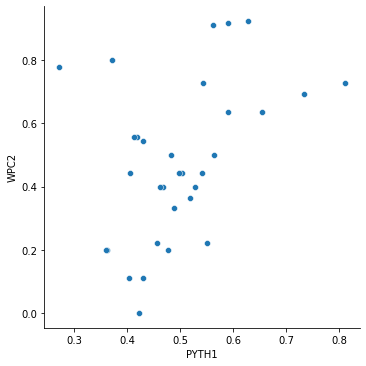

In [17]:
# Plot pythagorean expectation for first half against win percentage in second half
sns.relplot(x='PYTH1',y='WPC2', data=second_half_predictor)

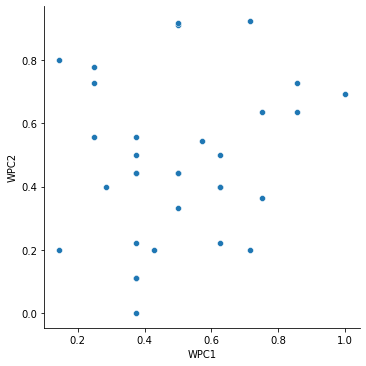

In [18]:
# Plot win percentage in first half against sin percentage in second half
sns.relplot(x='WPC1',y='WPC2', data=second_half_predictor)

In [19]:
# Generate df of key variables correlations
# Correlation may/would be better if using all of season 2021 data and all of season 2022 data instead of splitting one season in half.
# This is still a useful metric and example of how one would use pythagorean expectation to predict future win %
keyvars = second_half_predictor[['TEAM','WPC2','WPC1','PYTH1','PYTH2']]
keyvars.corr()

,WPC2,WPC1,PYTH1,PYTH2
WPC2,1.000000,0.181786,0.415829,0.917899
WPC1,0.181786,1.000000,0.764638,0.234928
PYTH1,0.415829,0.764638,1.000000,0.396509
PYTH2,0.917899,0.234928,0.396509,1.000000


In [20]:
# Sort key variables highest to lowest
keyvars = keyvars.sort_values(by=['WPC2'], ascending=False)
keyvars

,TEAM,WPC2,WPC1,PYTH1,PYTH2
15,Kansas City Chiefs,0.923077,0.714286,0.626997,0.637875
27,San Francisco 49ers,0.916667,0.500000,0.589065,0.751669
6,Cincinnati Bengals,0.909091,0.500000,0.562610,0.679699
10,Detroit Lions,0.800000,0.142857,0.371540,0.657696
26,Pittsburgh Steelers,0.777778,0.250000,0.270631,0.614198
3,Buffalo Bills,0.727273,0.857143,0.810993,0.591472
14,Jacksonville Jaguars,0.727273,0.250000,0.542348,0.563650
25,Philadelphia Eagles,0.692308,1.000000,0.733970,0.657291
8,Dallas Cowboys,0.636364,0.750000,0.654363,0.646124
20,Minnesota Vikings,0.636364,0.857143,0.590723,0.434075
